# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Importamos los datos

In [4]:
path = '../../../Base de datos/Campo 100 puntos'

## Datos de entrenamiento

### Datos

In [5]:
campvectrain = np.load(path + '/campvectrain.npy')
campvectrain = np.transpose(campvectrain, (0,2,3,1))

In [6]:
np.shape(campvectrain)

(7000, 100, 100, 2)

### Coeficientes

In [7]:
coefcampvectrain = np.load(path + '/coefcampvectrain.npy')

In [8]:
np.shape(coefcampvectrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
campvectest = np.load(path + '/campvectest.npy')
campvectest = np.transpose(campvectest, (0,2,3,1))

In [10]:
np.shape(campvectest)

(1000, 100, 100, 2)

### Coeficientes

In [11]:
coefcampvectest = np.load(path + '/coefcampvectest.npy')

In [12]:
np.shape(coefcampvectest)

(1000, 7)

## Datos de validación

### Datos

In [13]:
campvecval = np.load(path + '/campvecval.npy')
campvecval = np.transpose(campvecval, (0,2,3,1))

In [14]:
np.shape(campvecval)

(2000, 100, 100, 2)

### Coeficienes

In [15]:
coefcampvecval = np.load(path + '/coefcampvecval.npy')

In [16]:
np.shape(coefcampvecval)

(2000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((campvectrain, coefcampvectrain))
test_dataset = tf.data.Dataset.from_tensor_slices((campvectest, coefcampvectest))
val_dataset = tf.data.Dataset.from_tensor_slices((campvecval, coefcampvecval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(100, 100, 2), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 1
SHUFFLE_BUFFER_SIZE = 1

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [20]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [21]:
model = Sequential()
# Primera capa convolucional
model.add(Conv2D(50, (5, 5), activation='tanh', input_shape=(100, 100, 2),kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Segunda capa convolucional
model.add(Conv2D(24, (5, 5), activation='tanh',kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001) ))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Tercera capa convolucional
model.add(Conv2D(11, (5, 5), activation='tanh',kernel_initializer=H'glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(50, (5, 5), activation='tanh',kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())

model.add(Dense(200, activation='tanh', kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(100, activation='tanh', kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(50,activation = 'relu', kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(Dense(7, activation= custom_activation))


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 50)        2550      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 50)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 24)        30024     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 24)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 11)        6611      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 9, 11)         0

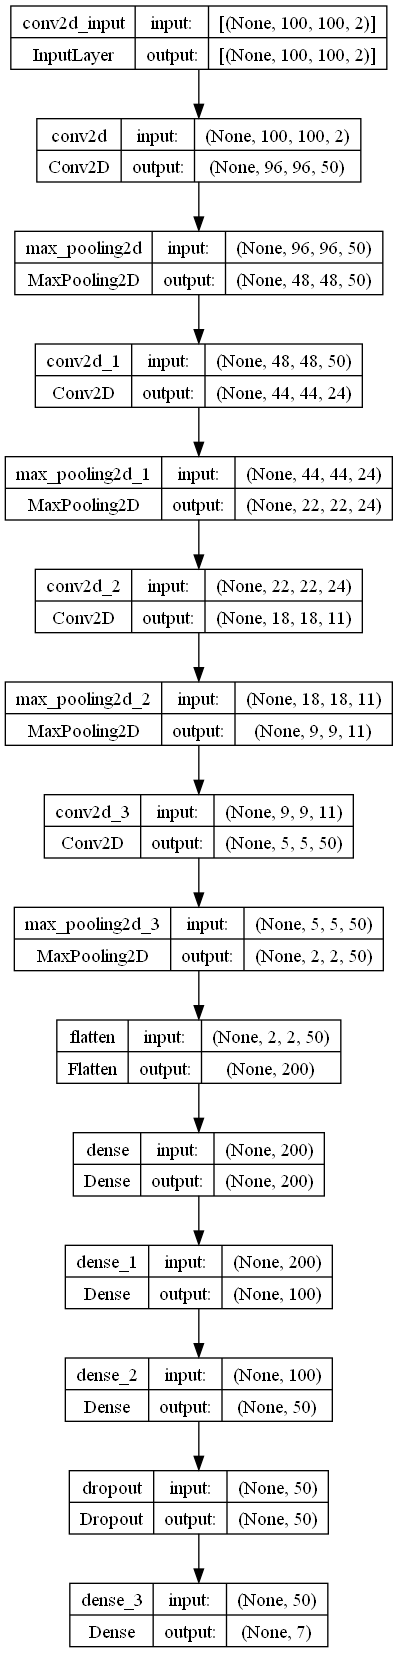

In [23]:
keras.utils.plot_model(model,show_shapes=True)

# Entrenamos el modelo

In [24]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=10.0)

In [27]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def desviacion_total(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    return total_loss

metrics = [mse_component(i) for i in range(7)] + [desviacion_total]


In [28]:
model.compile(optimizer= optimizer,
              loss= 'mae',
              metrics= metrics)

In [29]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [30]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)
reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/1000
7000/7000 [==============================] - 79s 11ms/step - loss: 3.9351 - a_1: 2.7923 - a_2: 2.7608 - b_1: 2.7051 - b_2: 2.5446 - d_1: 1.7079 - d_2: 1.6923 - n: 1.5906 - desviacion_total: 15.7936 - val_loss: 2.3453 - val_a_1: 2.6597 - val_a_2: 2.7024 - val_b_1: 2.5726 - val_b_2: 2.1463 - val_d_1: 1.3321 - val_d_2: 1.2529 - val_n: 1.4951 - val_desviacion_total: 14.1610 - lr: 0.0010
Epoch 2/1000
7000/7000 [==============================] - 76s 11ms/step - loss: 2.3240 - a_1: 2.7061 - a_2: 2.6828 - b_1: 2.6097 - b_2: 2.2284 - d_1: 1.3548 - d_2: 1.3919 - n: 1.5078 - desviacion_total: 14.4816 - val_loss: 2.1791 - val_a_1: 2.6510 - val_a_2: 2.6911 - val_b_1: 2.5723 - val_b_2: 2.0234 - val_d_1: 1.3796 - val_d_2: 1.3322 - val_n: 1.4820 - val_desviacion_total: 14.1316 - lr: 0.0010
Epoch 3/1000
7000/7000 [==============================] - 79s 11ms/step - loss: 2.3300 - a_1: 2.7041 - a_2: 2.6716 - b_1: 2.5984 - b_2: 2.0656 - d_1: 1.3989 - d_2: 1.4037 - n: 1.4934 - desviacion_total:

7000/7000 [==============================] - 73s 10ms/step - loss: 2.3572 - a_1: 2.6534 - a_2: 2.4860 - b_1: 2.2781 - b_2: 1.8269 - d_1: 1.5259 - d_2: 1.3748 - n: 1.4412 - desviacion_total: 13.5862 - val_loss: 2.2190 - val_a_1: 2.4678 - val_a_2: 2.3818 - val_b_1: 1.9504 - val_b_2: 1.8426 - val_d_1: 1.2272 - val_d_2: 1.1999 - val_n: 1.3762 - val_desviacion_total: 12.4460 - lr: 0.0010
Epoch 42/1000
7000/7000 [==============================] - 73s 10ms/step - loss: 2.4588 - a_1: 2.5523 - a_2: 2.5672 - b_1: 2.1633 - b_2: 1.9749 - d_1: 1.5159 - d_2: 1.5398 - n: 1.4342 - desviacion_total: 13.7476 - val_loss: 2.1881 - val_a_1: 2.4633 - val_a_2: 2.4416 - val_b_1: 1.9770 - val_b_2: 1.6115 - val_d_1: 1.2399 - val_d_2: 1.2712 - val_n: 1.3782 - val_desviacion_total: 12.3828 - lr: 0.0010
Epoch 43/1000
7000/7000 [==============================] - 75s 11ms/step - loss: 2.5210 - a_1: 2.5815 - a_2: 2.5537 - b_1: 2.2277 - b_2: 2.0333 - d_1: 1.5660 - d_2: 1.4709 - n: 1.4279 - desviacion_total: 13.8611 - 

7000/7000 [==============================] - 74s 11ms/step - loss: 2.4598 - a_1: 2.5689 - a_2: 2.4386 - b_1: 2.1359 - b_2: 2.0508 - d_1: 1.5320 - d_2: 1.5036 - n: 1.4141 - desviacion_total: 13.6440 - val_loss: 2.0501 - val_a_1: 2.4398 - val_a_2: 2.4548 - val_b_1: 1.8040 - val_b_2: 1.7127 - val_d_1: 1.3033 - val_d_2: 1.2717 - val_n: 1.3667 - val_desviacion_total: 12.3530 - lr: 0.0010
Epoch 82/1000
7000/7000 [==============================] - 74s 11ms/step - loss: 2.4027 - a_1: 2.5289 - a_2: 2.5040 - b_1: 2.1912 - b_2: 1.9925 - d_1: 1.6013 - d_2: 1.4330 - n: 1.4186 - desviacion_total: 13.6694 - val_loss: 2.7693 - val_a_1: 2.6873 - val_a_2: 2.3916 - val_b_1: 2.8106 - val_b_2: 1.9241 - val_d_1: 2.1384 - val_d_2: 1.2753 - val_n: 1.4063 - val_desviacion_total: 14.6335 - lr: 0.0010
Epoch 83/1000
7000/7000 [==============================] - 75s 11ms/step - loss: 2.4403 - a_1: 2.5210 - a_2: 2.5606 - b_1: 2.1223 - b_2: 2.1134 - d_1: 1.5859 - d_2: 1.4645 - n: 1.4265 - desviacion_total: 13.7942 - 

7000/7000 [==============================] - 75s 11ms/step - loss: 2.3862 - a_1: 2.5934 - a_2: 2.3949 - b_1: 2.1239 - b_2: 2.0487 - d_1: 1.5829 - d_2: 1.5126 - n: 1.3936 - desviacion_total: 13.6500 - val_loss: 2.5425 - val_a_1: 2.4008 - val_a_2: 2.2235 - val_b_1: 2.0752 - val_b_2: 2.0154 - val_d_1: 1.4520 - val_d_2: 1.3881 - val_n: 1.3507 - val_desviacion_total: 12.9059 - lr: 0.0010
Epoch 122/1000
7000/7000 [==============================] - 76s 11ms/step - loss: 2.4396 - a_1: 2.6096 - a_2: 2.4261 - b_1: 2.1673 - b_2: 2.1947 - d_1: 1.5985 - d_2: 1.4900 - n: 1.4222 - desviacion_total: 13.9084 - val_loss: 2.5394 - val_a_1: 2.4927 - val_a_2: 2.6287 - val_b_1: 2.0167 - val_b_2: 2.2999 - val_d_1: 1.4320 - val_d_2: 1.3743 - val_n: 1.4426 - val_desviacion_total: 13.6869 - lr: 0.0010
Epoch 123/1000
7000/7000 [==============================] - 75s 11ms/step - loss: 2.3941 - a_1: 2.5397 - a_2: 2.5461 - b_1: 1.9682 - b_2: 2.2364 - d_1: 1.4857 - d_2: 1.6413 - n: 1.4088 - desviacion_total: 13.8262 

KeyboardInterrupt: 

# Analizamos accuracy y loss

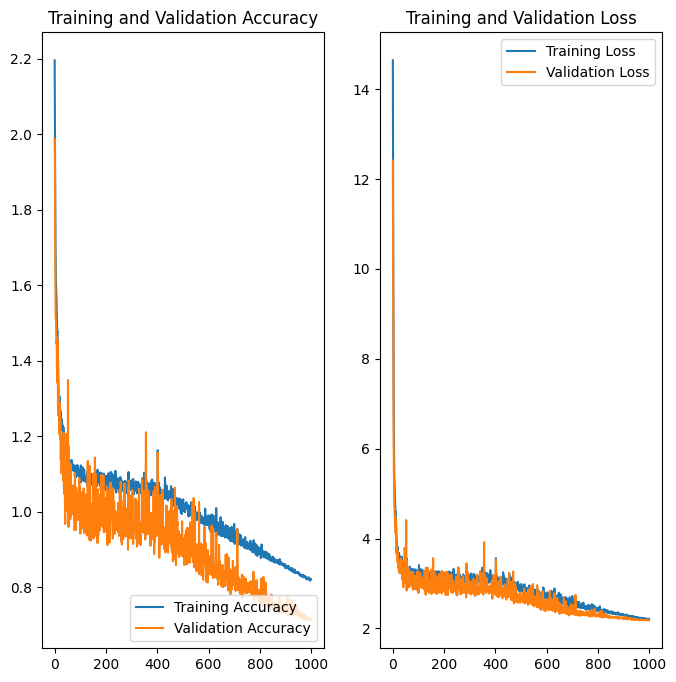

In [28]:
acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(val_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluamos el modelo

In [49]:
test_loss, test_acc = model.evaluate(campvecval,coefcampvecval)

32/32 [==============================] - 0s 6ms/step - loss: 2.1843 - mae: 0.7138


In [51]:
predictions = model.predict(campvecval)

32/32 [==============================] - 0s 4ms/step


In [52]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Calcula el MAE
mae = mean_absolute_error(coefcampvecval, predictions)

# Calcula la desviación estándar del error
error = coefcampvecval - predictions
std_dev = np.std(error)

# Calcula el error absoluto máximo
max_error = np.max(np.abs(error))

print(f"MAE: {mae}, Desviación estándar del error: {std_dev}, Error absoluto máximo: {max_error}")

MAE: 0.7138420440191735, Desviación estándar del error: 1.3789945856978567, Error absoluto máximo: 8.277273297309875


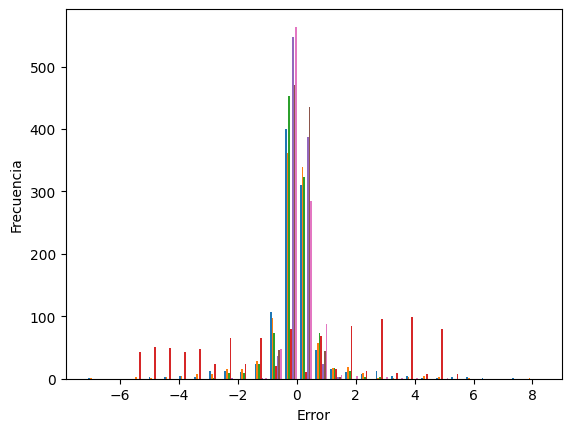

In [53]:
import matplotlib.pyplot as plt

plt.hist(error, bins=30)
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.show()

In [55]:
from sklearn.metrics import r2_score

r2 = r2_score(coefcampvecval, predictions)
r2

0.8047254406071674

In [57]:
error_percentile_90 = np.percentile(np.abs(error), 90)
error_percentile_90

2.296183919906619

# Guardamos los datos de Accuracy y Loss

In [58]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales/History 100,200/historyconvcampvec100.csv', index=False)

# Guardamos el modelo

In [59]:
path_to_save = '../../../Modelos/Modelos 100,200/'

In [60]:
model.save(path_to_save + '/convolucionalcv100.h5')

# Importamos el modelo

In [61]:
def custom_activation(x):
    return 10 * tf.np.sigmoid(x)

In [62]:
import keras
import tensorflow as tf
custom_objects = {'custom_activation': custom_activation}
new_model = keras.models.load_model('../../../Modelos/Modelos 100,200/convolucionalcv100.h5', custom_objects=custom_objects)

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [69]:
import random
from scipy.integrate import solve_ivp

campvec = []
coef = []
contador = 0
for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        # dX_dt=a1/(1+Y**n)-d1*X+b1
        # dY_dt=a2/(1+X**n)-d2*Y+b2
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b2

        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 10
    y_range_neg = 0
    y_range_pos =10

    y1 = np.linspace(x_range_neg, x_range_pos, 100)
    y2 = np.linspace(y_range_neg, y_range_pos, 100)

    Y1, Y2 = np.meshgrid(y1, y2)
    
    t1 = 0

    u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

    NI, NJ = Y1.shape

    u1, v1 = f(t1, [Y1, Y2])
    u, v = f(t1, [Y1, Y2])
    M = (np.hypot(u, v))
    u /= M
    v /= M

    campvecci = np.append([u1], [v1], axis=0)

    campvec = campvecci
    print('--------------------------------------------')
    print(coef1)

    
campvec = np.array(campvec)
coef = np.array(coef)


--------------------------------------------
[1, 1, 2, 10, 4, 6, 3]


In [70]:
campvecnone = campvec[None, :]
campvecnone = np.transpose(campvecnone, (0,2,3,1))

## Predecimos con los datos nuevos

In [71]:
new_predictions = new_model.predict(campvecnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 13ms/step
[[1. 1. 2. 5. 4. 6. 3.]]


## Encontramos puntos de equilibro datos reales

In [72]:
from scipy.optimize import fsolve
# Sistema de ecuaciones
def system(Y):
    X, Y = Y
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1
    return [dX_dt, dY_dt]

# Adivinanza inicial para X, Y
initial_guess = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_reales = fsolve(system, initial_guess)
primer_cuadrante_reales = tuple(primer_cuadrante_reales)


print(primer_cuadrante_reales)

(0.7286715035930441, 0.45350568008801223)


## Graficamos con los coeficientes reales

Text(0, 0.5, 'Concentración Y')

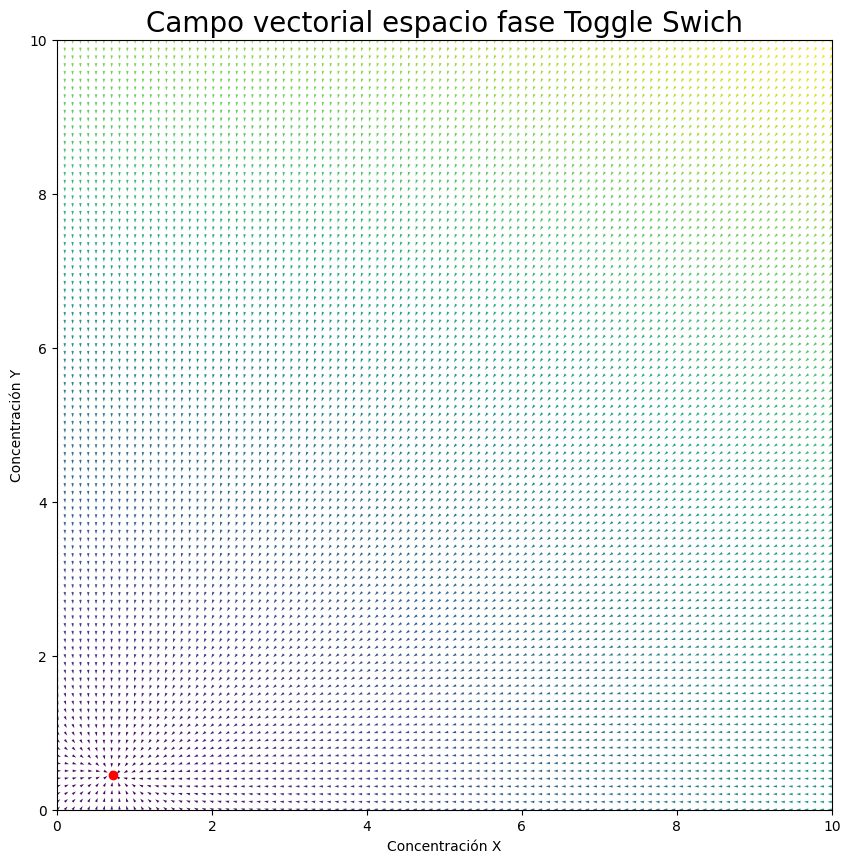

In [73]:
import matplotlib.pyplot as plt

x_values = primer_cuadrante_reales[0]
y_values =primer_cuadrante_reales[1]
y1 = np.linspace(0, 10, 100)
y2 = np.linspace(0, 10, 100)
Y1, Y2 = np.meshgrid(y1, y2)
t1 = 0
u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)
NI, NJ = Y1.shape        
u,v = np.array(campvec)[0,:,:], np.array(campvec)[1,:,:]
M = (np.hypot(u,v))
u /= M
v /= M

plt.figure(figsize=(10,10))
Q = plt.quiver(Y1, Y2, u, v, M, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.scatter(x_values, y_values, color='red')  # Puedes cambiar el color como prefieras
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

## Encontramos puntos de equilibro datos predecidos

In [74]:
a1pred = new_predictions[0,0]
a2pred = new_predictions[0,1]
b1pred = new_predictions[0,2]
b2pred = new_predictions[0,3]
d1pred = new_predictions[0,4]
d2pred = new_predictions[0,5]
npred = new_predictions[0,6]

def systempred(Ypred):
    Xpred, Ypred = Ypred
    dXpred_dt = a1pred/(1+Ypred**npred)-d1pred*Xpred+b1pred
    dYpred_dt = a2pred/(1+Xpred**npred)-d2pred*Ypred+b1pred
    return [dXpred_dt, dYpred_dt]

# Adivinanza inicial para X, Y
initial_guesspred = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_predecidos = fsolve(systempred, initial_guesspred)
primer_cuadrante_predecidos = tuple(primer_cuadrante_predecidos)


print(primer_cuadrante_predecidos)

(0.7286715035930441, 0.45350568008801223)


## Graficamos con los coeficientes predecidos

Text(0, 0.5, 'Concentración Y')

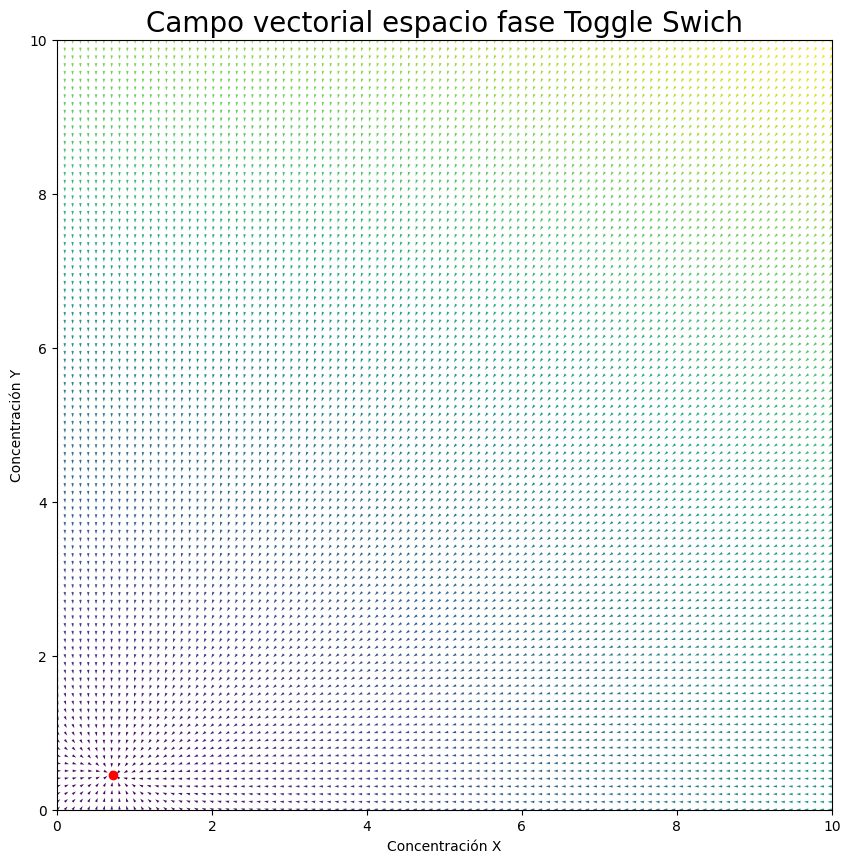

In [75]:
import matplotlib.pyplot as plt

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1pred/(1+Y**npred)-d1pred*X+b1pred
    dY_dt = a2pred/(1+X**npred)-d2pred*Y+b1pred

    return [dX_dt, dY_dt]

x_range_neg = 0
x_range_pos = 10
y_range_neg = 0
y_range_pos = 10

y1pred = np.linspace(x_range_neg, x_range_pos, 100)
y2pred = np.linspace(y_range_neg, y_range_pos, 100)

Y1pred, Y2pred = np.meshgrid(y1pred, y2pred)
    
t1 = 0

upred, vpred = np.zeros(Y1pred.shape), np.zeros(Y2pred.shape)

NI, NJ = Y1.shape

u1pred, v1pred = f(t1, [Y1, Y2])
upred, vpred = f(t1, [Y1, Y2])
Mpred = (np.hypot(upred, vpred))
upred /= Mpred
vpred /= Mpred


x_valuespred = primer_cuadrante_predecidos[0]
y_valuespred =primer_cuadrante_predecidos[1]
plt.figure(figsize=(10, 10))
Q = plt.quiver(Y1, Y2, upred, vpred, Mpred, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([x_range_neg, x_range_pos])
plt.ylim([y_range_neg, y_range_pos])
plt.scatter(x_valuespred, y_valuespred, color='red')  # Puedes cambiar el color como prefieras
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

## Graficamos ambos

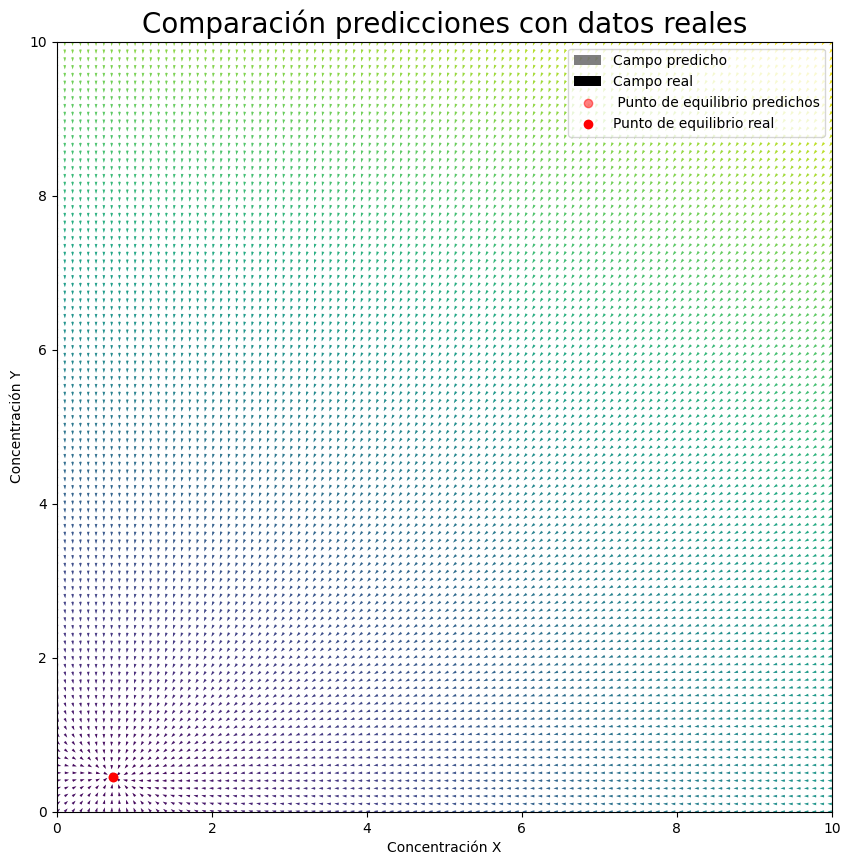

In [77]:
#%matplotlib qt
fig, ax = plt.subplots(figsize=(10, 10))

# Primero graficamos la predicción, que debería ser más clara (alpha < 1)
Q = ax.quiver(Y1, Y2, upred, vpred, Mpred, angles='xy', alpha=0.5, label = "Campo predicho")

# Luego, graficamos los datos originales, que serán más oscuros (alpha = 1)
Q1 = ax.quiver(Y1, Y2, u, v, M, angles='xy', alpha=1, label = "Campo real")

ax.scatter(x_valuespred, y_valuespred, color='red', alpha = 0.5, label = " Punto de equilibrio predichos")
ax.scatter(x_values, y_values, color='red', alpha = 1, label = "Punto de equilibrio real")
ax.set_title('Comparación predicciones con datos reales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')
ax.legend(loc='upper right')  # Agregar leyenda a la gráfica
plt.show()

## Graficamos las diferencias

0.0


C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\matplotlib\quiver.py:658: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\matplotlib\quiver.py:658: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


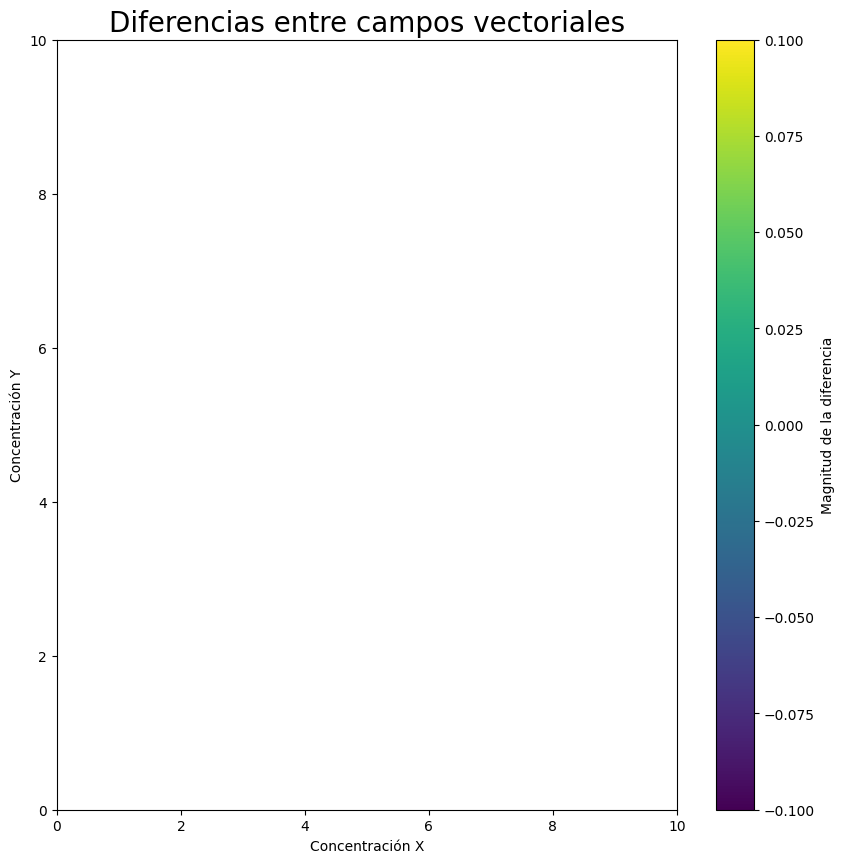

In [78]:
fig, ax = plt.subplots(figsize=(10, 10))

# Calculamos las diferencias
u_diff = u - upred
v_diff = v - vpred

# Aseguramos que ningún vector tenga una magnitud exactamente igual a cero
epsilon = 1e-7
u_diff2 = u_diff + epsilon
v_diff2 = v_diff + epsilon

# Ahora calculamos la magnitud
#M_diff = np.hypot(u_diff2, v_diff2)
M_diff = np.hypot(u_diff, v_diff)

#Calcula la magnitud de los vectores
magnitudes = np.sqrt(u_diff**2 + v_diff**2)

# Calcula el rango de las magnitudes
rango = (np.max(magnitudes) - np.min(magnitudes))*30
print(rango)
# Escala para las flechas. Aumenta este valor si las flechas son demasiado grandes.
scale = 70

# Graficamos las diferencias
#Q = ax.quiver(Y1, Y2, u_diff2, v_diff2, M_diff, angles='xy')
Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff, angles='xy', scale = rango)
#Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff, angles='xy')


ax.set_title('Diferencias entre campos vectoriales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

# Creamos una leyenda para la magnitud de las flechas
cbar = plt.colorbar(Q, ax=ax)
cbar.set_label('Magnitud de la diferencia')

plt.show()

In [79]:
M_diff.mean()

0.0

## Errores relativos

C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\matplotlib\quiver.py:658: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\Users\rafae\anaconda3\envs\tfgpu\lib\site-packages\matplotlib\quiver.py:658: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


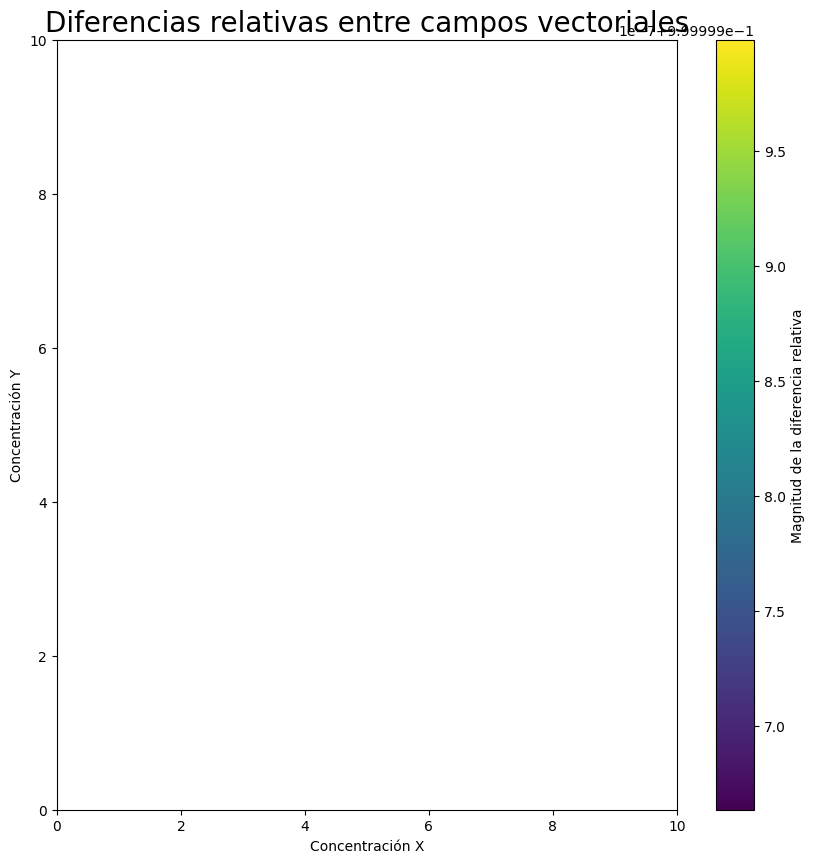

In [80]:
fig, ax = plt.subplots(figsize=(10, 10))

# Calculamos las diferencias
u_diff = u - upred
v_diff = v - vpred

# Aseguramos que ningún vector tenga una magnitud exactamente igual a cero
epsilon = 1e-7

# Calculamos la magnitud del vector original y de la diferencia
M_orig = np.hypot(u1, v1) + epsilon
M_diff = np.hypot(u1pred, v1pred)

# Calculamos la diferencia relativa
M_diff_rel = M_diff / M_orig

#Calcula la magnitud de los vectores
magnitudes = np.sqrt(u_diff**2 + v_diff**2)

# Calcula el rango de las magnitudes
rango = (np.max(magnitudes) - np.min(magnitudes))*30

# Graficamos las diferencias relativas
Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff_rel, angles='xy', scale = rango)

ax.set_title('Diferencias relativas entre campos vectoriales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

# Creamos una leyenda para la magnitud de las flechas
cbar = plt.colorbar(Q, ax=ax)
cbar.set_label('Magnitud de la diferencia relativa')

plt.show()

In [14]:
max_index_flattened = M_diff_rel.argmax()
max_coords = np.unravel_index(max_index_flattened, M_diff_rel.shape)
M_orig[max_coords]
print('El valor máximo de error relativo es de:', M_diff_rel.max() )
print('El valor de u1 en el error relativo máximo es:',u1[max_coords])
print('El valor de u1pred en el error relativo máximo es:',u1pred[max_coords])
print('El valor de v1 en el error relativo máximo es:',v1[max_coords])
print('El valor de v1pred en el error relativo máximo es:',v1pred[max_coords])

El valor máximo de error relativo es de: 2.596865985467346
El valor de u1 en el error relativo máximo es: -1.2929292929292924
El valor de u1pred en el error relativo máximo es: -5.939393939393938
El valor de v1 en el error relativo máximo es: 2.0442680927367087
El valor de v1pred en el error relativo máximo es: 2.0442680927367087


In [15]:
np.sqrt(u1pred[max_coords]**2+v1pred[max_coords]**2)/np.sqrt(u1[max_coords]**2+v1[max_coords]**2)

2.5968660928281335